![logo](https://github.com/heberrossi/Curso_CientistaDeDados_EBAC_Exercicios/blob/main/logo/ebac_logo-data_science.png?raw=true)


# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t
import warnings
warnings.filterwarnings('ignore')

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               750000 non-null  datetime64[ns]
 1   index                  750000 non-null  int64         
 2   sexo                   750000 non-null  object        
 3   posse_de_veiculo       750000 non-null  object        
 4   posse_de_imovel        750000 non-null  object        
 5   qtd_filhos             750000 non-null  int64         
 6   tipo_renda             750000 non-null  object        
 7   educacao               750000 non-null  object        
 8   estado_civil           750000 non-null  object        
 9   tipo_residencia        750000 non-null  object        
 10  idade                  750000 non-null  int64         
 11  tempo_emprego          624043 non-null  float64       
 12  qt_pessoas_residencia  750000 non-null  floa

In [3]:
df.set_index('data_ref', inplace=True)

df_train = df[:'2015-12-01']
df_test = df['2016-01-01':]

In [4]:
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [5]:
df_train['mes'] = df_train['data_ref'].dt.month
df_train['mes'].value_counts()

mes
1     50000
2     50000
3     50000
4     50000
5     50000
6     50000
7     50000
8     50000
9     50000
10    50000
11    50000
12    50000
Name: count, dtype: int64

In [6]:
df_train2 = df_train.copy()
df_train2['tempo_emprego'] = df_train2['tempo_emprego'].fillna(df_train2['tempo_emprego'].mean())

In [7]:
qualitativas = df_train.select_dtypes(include=['object', 'category', 'bool'])
qualitativas

,sexo,posse_de_veiculo,posse_de_imovel,tipo_renda,educacao,estado_civil,tipo_residencia,mau
0,F,N,N,Empresário,Médio,Solteiro,Casa,False
1,F,S,S,Assalariado,Médio,Casado,Casa,False
2,F,N,N,Assalariado,Médio,Casado,Casa,False
3,F,N,N,Assalariado,Médio,Casado,Casa,False
4,F,S,N,Assalariado,Superior incompleto,Solteiro,Casa,False
...,...,...,...,...,...,...,...,...
599995,F,S,N,Assalariado,Médio,União,Casa,False
599996,M,S,N,Empresário,Superior completo,Casado,Casa,False
599997,F,N,N,Pensionista,Médio,Casado,Casa,True
599998,F,N,N,Assalariado,Superior completo,Casado,Casa,True


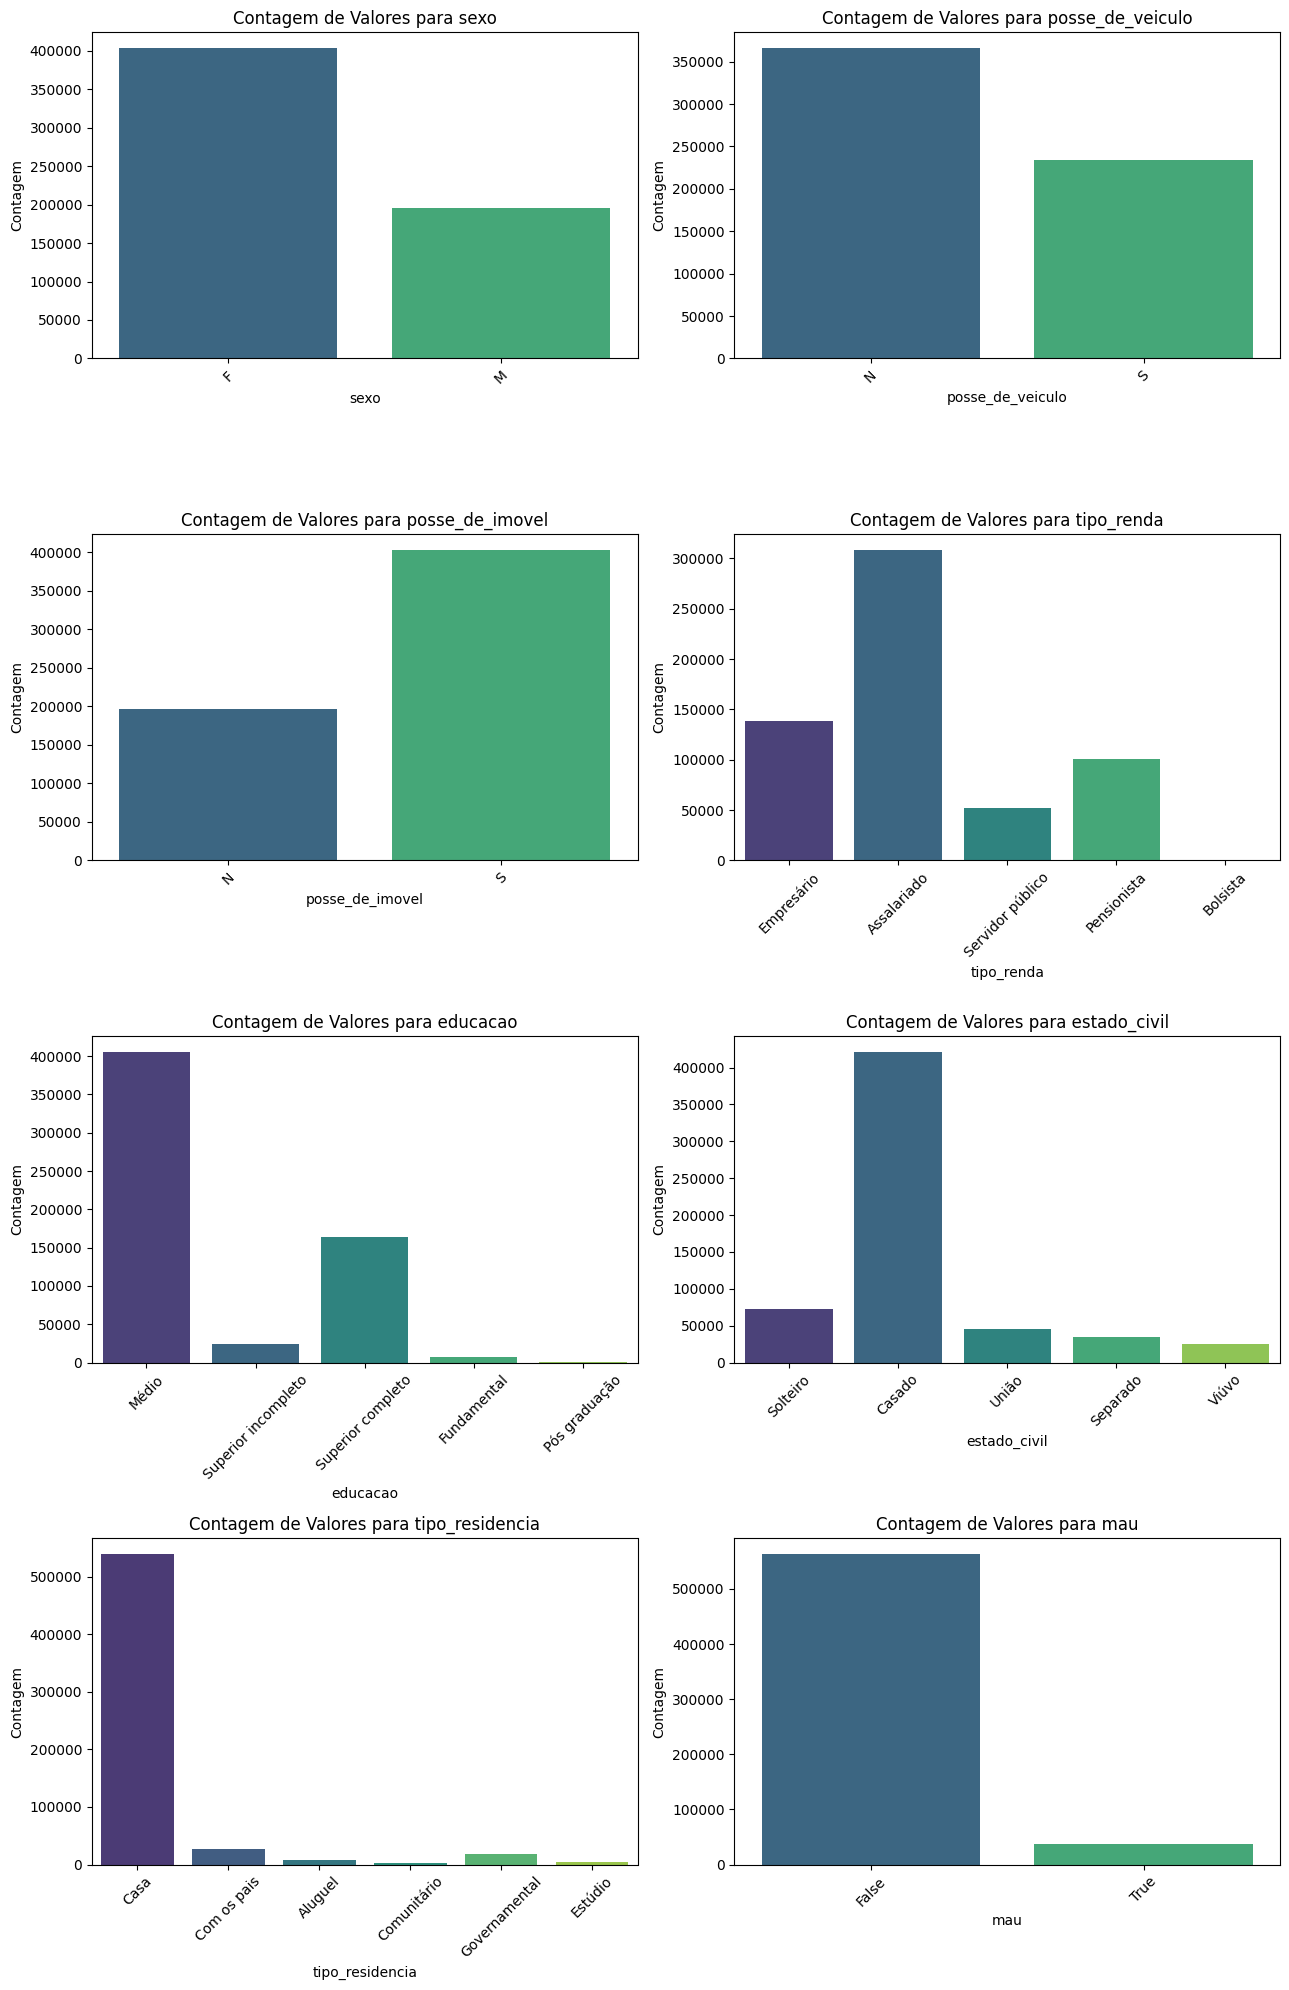

In [8]:
# Determinar o número de linhas e colunas de subplots
num_qualitativas = len(qualitativas.columns)
cols = 2
rows = (num_qualitativas + 1) // cols

# Criar a figura com subplots
fig, axes = plt.subplots(rows, cols, figsize=(13, 5 * rows))
axes = axes.flatten()  # Achatar o array de eixos para fácil iteração

for i, col in enumerate(qualitativas.columns):
    # Plotar gráfico de barras para a contagem de valores
    sns.countplot(data=qualitativas, x=col, palette='viridis', ax=axes[i])
    axes[i].set_title(f'Contagem de Valores para {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Contagem')
    axes[i].tick_params(axis='x', rotation=45)

# Remover eixos não utilizados
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [9]:
# Separar variáveis qualitativas e quantitativas
quantitativas = df_train.select_dtypes(include=['number'])
quantitativas.reset_index()
quantitativas.drop(columns=['index'], inplace=True)
quantitativas

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,mes
0,0,43,6.873973,1.0,2515.39,1
1,0,35,4.526027,2.0,3180.19,1
2,2,31,0.243836,4.0,1582.29,1
3,0,54,12.772603,2.0,13721.17,1
4,0,31,8.432877,1.0,2891.08,1
...,...,...,...,...,...,...
599995,0,47,23.690411,2.0,11009.92,12
599996,1,31,3.756164,3.0,4472.60,12
599997,0,62,NaN,2.0,5117.17,12
599998,0,40,12.939726,2.0,2885.45,12


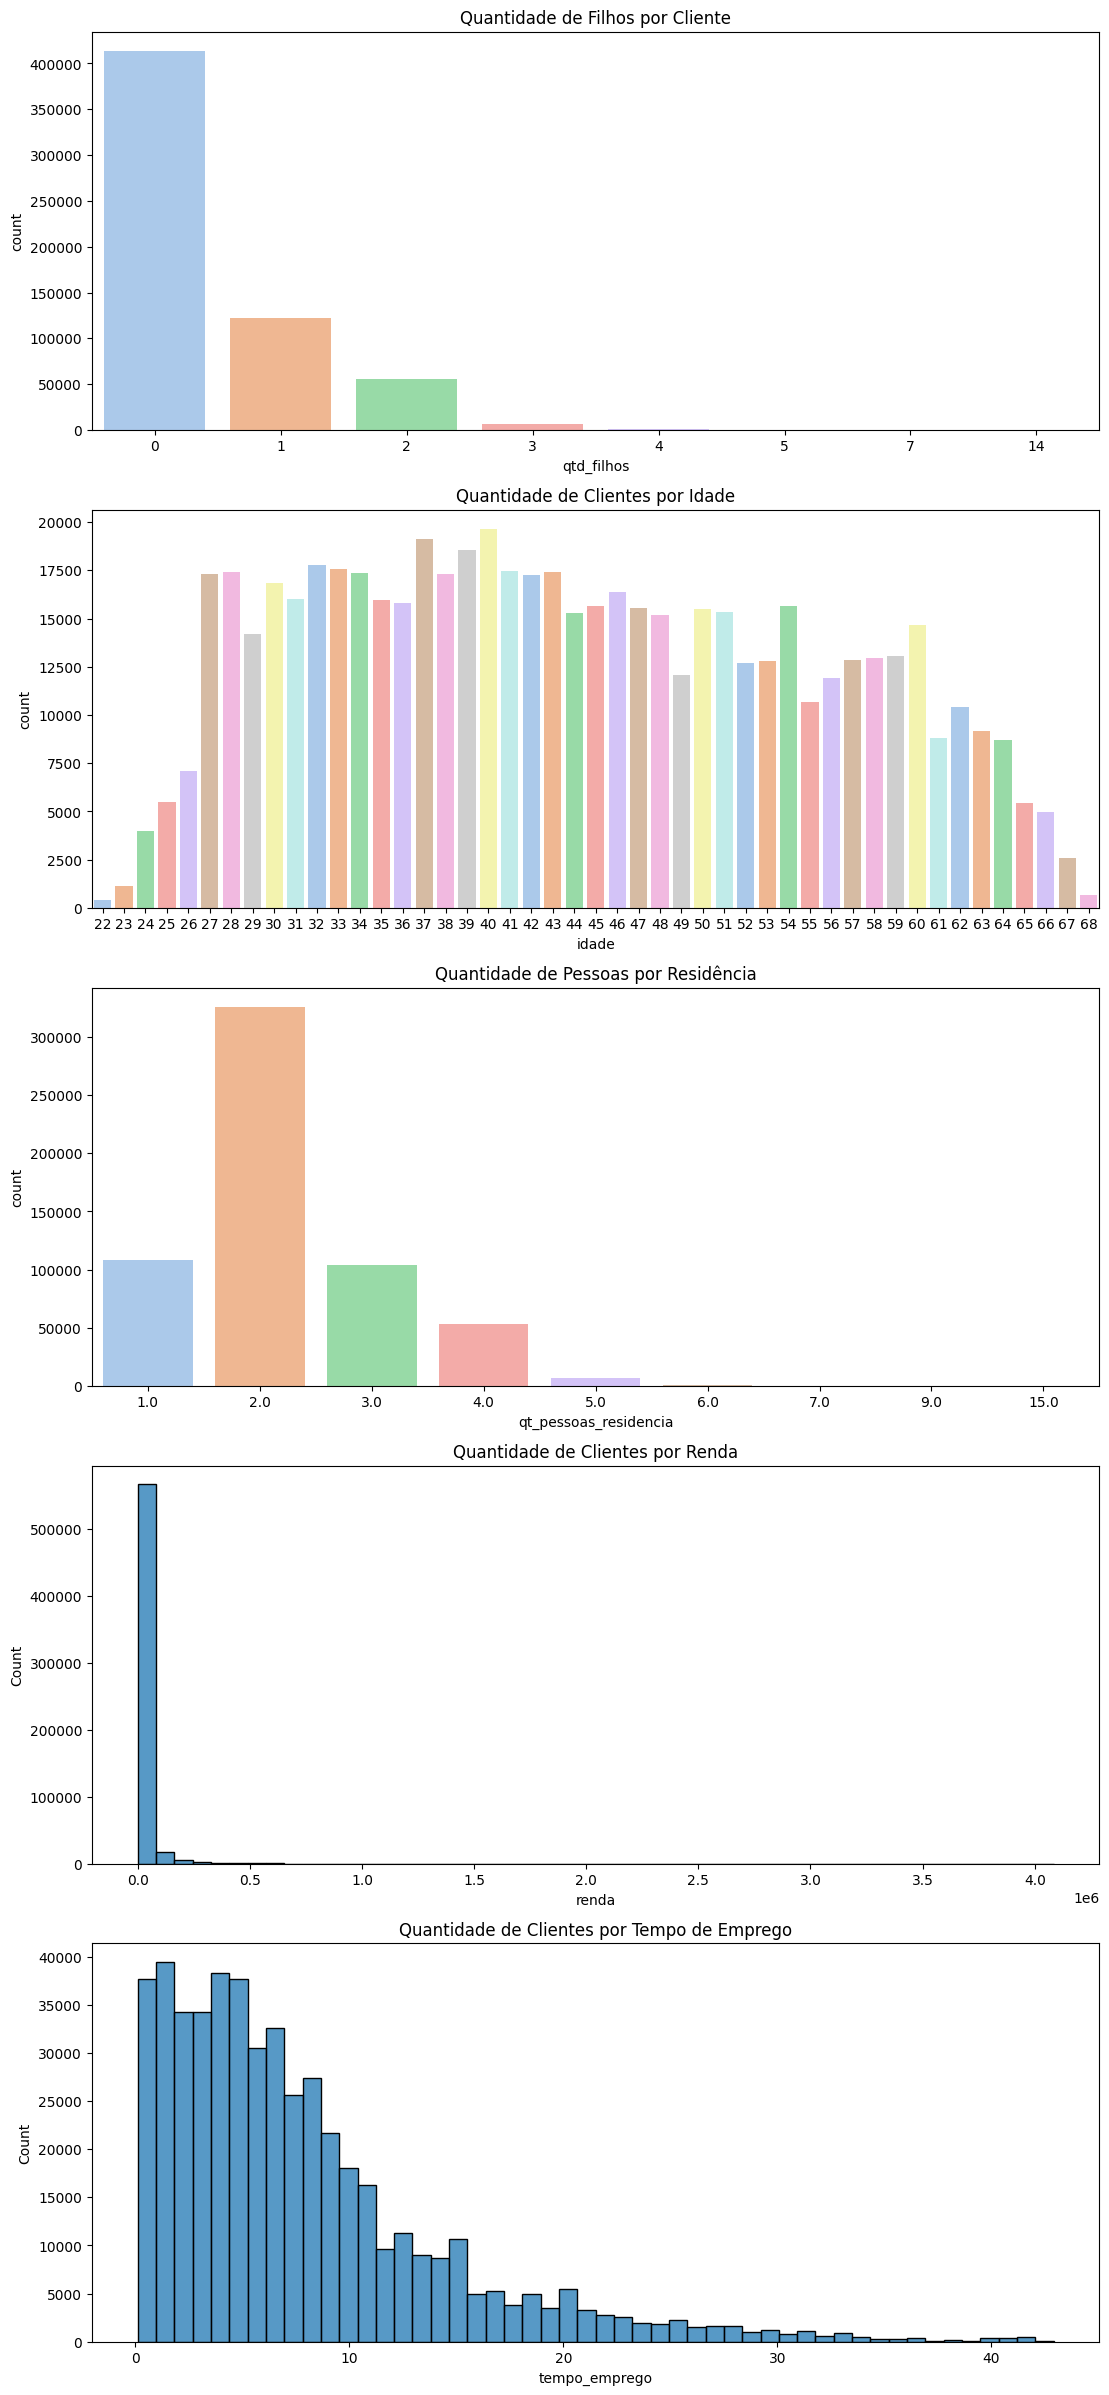

In [10]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize = (13, 30))

sns.countplot(data=df_train, x='qtd_filhos', palette='pastel', ax=ax[0])
ax[0].set_title('Quantidade de Filhos por Cliente')

sns.countplot(data=df_train, x='idade', palette='pastel', ax=ax[1])
ax[1].set_title('Quantidade de Clientes por Idade')

sns.countplot(data=df_train, x='qt_pessoas_residencia', palette='pastel', ax=ax[2])
ax[2].set_title('Quantidade de Pessoas por Residência')

sns.histplot(data=df_train, x='renda', bins = 50, palette='pastel', ax=ax[3])
ax[3].set_title('Quantidade de Clientes por Renda')

sns.histplot(data=df_train, x='tempo_emprego', bins = 50, palette='pastel', ax=ax[4])
ax[4].set_title('Quantidade de Clientes por Tempo de Emprego')

plt.show()

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

### Bivariada Qualitativa

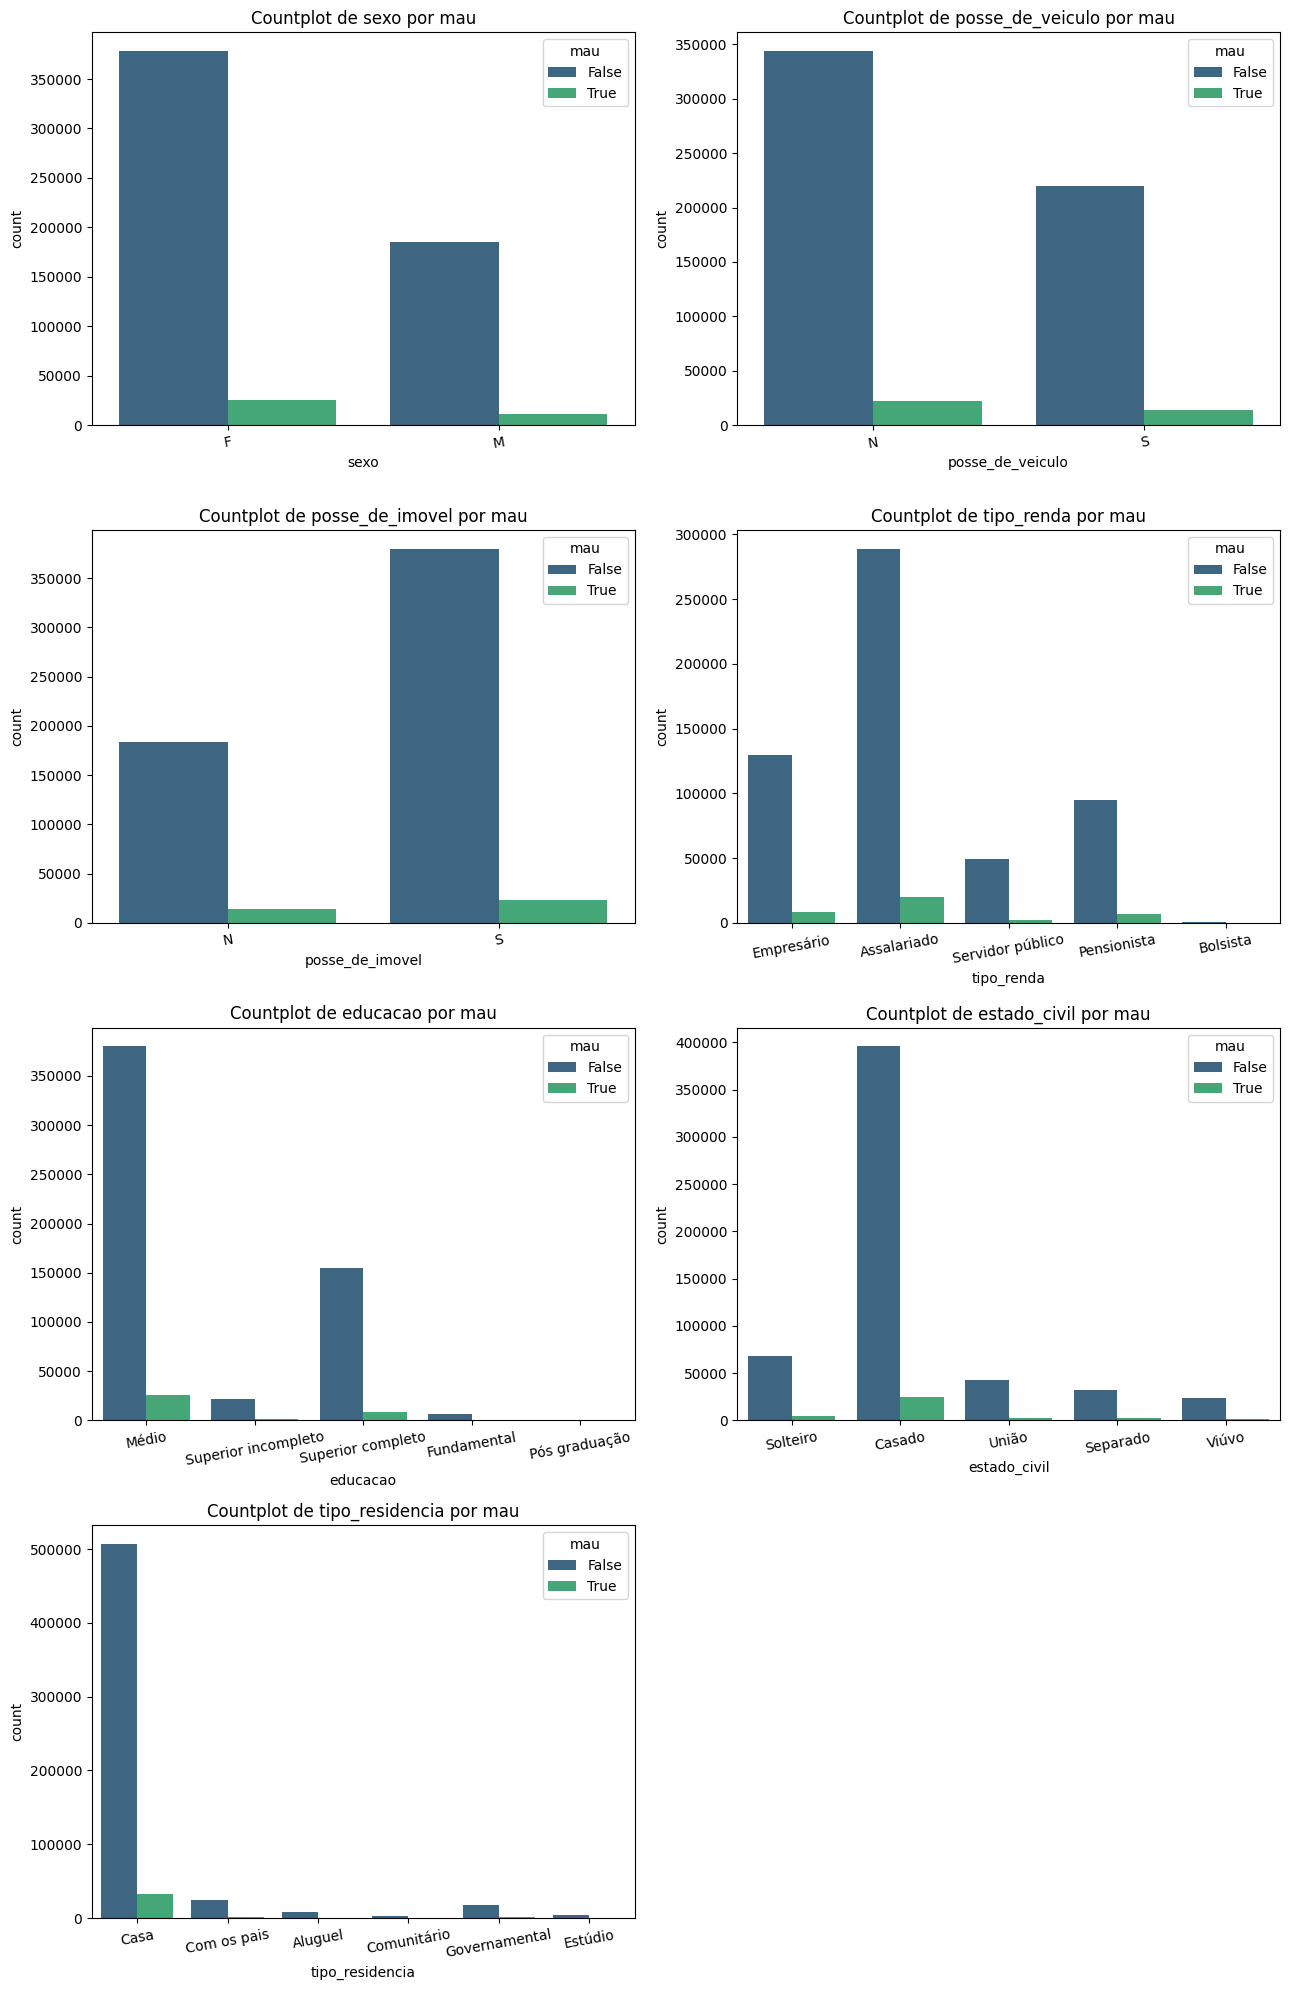

In [11]:
# Análise descritiva bivariada entre variáveis categóricas e a variável resposta 'MAU'
def descritiva_bivariada_com_MAU(df, resposta='mau'):
    cat_cols = qualitativas.columns
    cat_cols = [col for col in cat_cols if col != resposta]

    num_plots = len(cat_cols)
    fig, axes = plt.subplots((num_plots + 1) // 2, 2, figsize=(13, 5 * ((num_plots + 1) // 2)))
    axes = axes.flatten()

    for i, col in enumerate(cat_cols):
        # Countplot para variáveis categóricas
        sns.countplot(data=df, x=col, hue=resposta, ax=axes[i], palette='viridis')
        axes[i].set_title(f'Countplot de {col} por {resposta}')

        # Alterar o ângulo dos rótulos do eixo x para todos os gráficos
        axes[i].tick_params(axis='x', rotation=10)

     # Remover eixos não utilizados
    for j in range(num_plots, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Executar a análise
descritiva_bivariada_com_MAU(df_train)

### Bivariada Quantitativa

In [12]:
# Obter o número de valores diferentes (únicos) de cada variável
unique_counts = quantitativas.nunique()
print('Número de valores diferentes em cada variável:')
print(unique_counts)

Número de valores diferentes em cada variável:
qtd_filhos                    8
idade                        47
tempo_emprego              3004
qt_pessoas_residencia         9
renda                    112472
mes                          12
dtype: int64


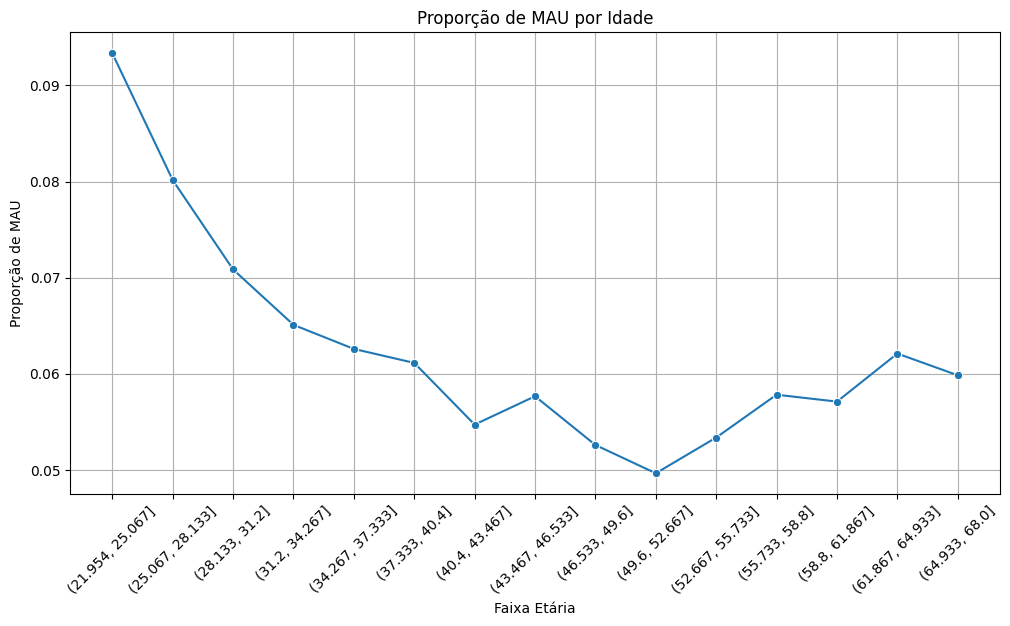

In [13]:
# Dividir a variável 'idade' em 15 intervalos
df_train['idade_bin'] = pd.cut(df_train['idade'], bins=15)

# Criar a figura e os eixos
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

# Calcular a média de idade_bin para cada categoria de MAU
media_idade = df_train.groupby('idade_bin')['mau'].mean().reset_index()

# Converter a 'idade_bin' para string
media_idade['idade_bin'] = media_idade['idade_bin'].astype(str)

sns.lineplot(data=media_idade, x='idade_bin', y='mau', marker='o', ax=ax)
plt.xticks(rotation=45)
plt.xlabel('Faixa Etária')
plt.ylabel('Proporção de MAU')
plt.title('Proporção de MAU por Idade')
plt.grid(True)
plt.show()

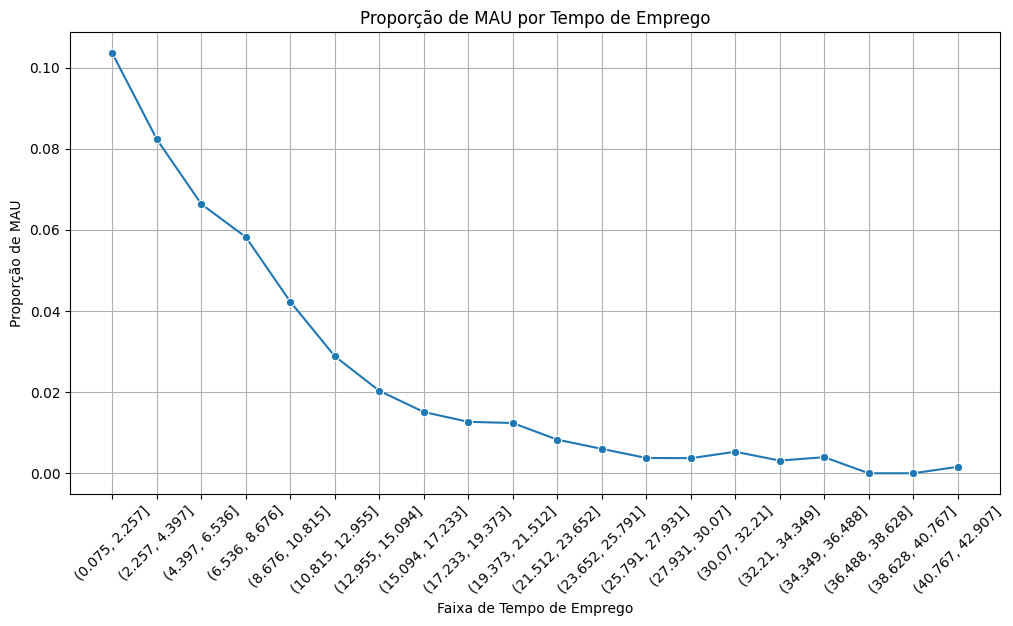

In [14]:
# Dividir a variável 'tempo_emprego' em 20 intervalos
df_train2['tempo_emprego_bin'] = pd.cut(df_train2['tempo_emprego'], bins=20)

# Criar a figura e os eixos
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

# Calcular a média de tempo_emprego para cada categoria de MAU
media_tempo_emprego = df_train2.groupby('tempo_emprego_bin')['mau'].mean().reset_index()

# Converter a 'tempo_emprego_bin' para string
media_tempo_emprego['tempo_emprego_bin'] = media_tempo_emprego['tempo_emprego_bin'].astype(str)

sns.lineplot(data=media_tempo_emprego, x='tempo_emprego_bin', y='mau', marker='o', ax=ax)
plt.xticks(rotation=45)
plt.xlabel('Faixa de Tempo de Emprego')
plt.ylabel('Proporção de MAU')
plt.title('Proporção de MAU por Tempo de Emprego')
plt.grid(True)
plt.show()

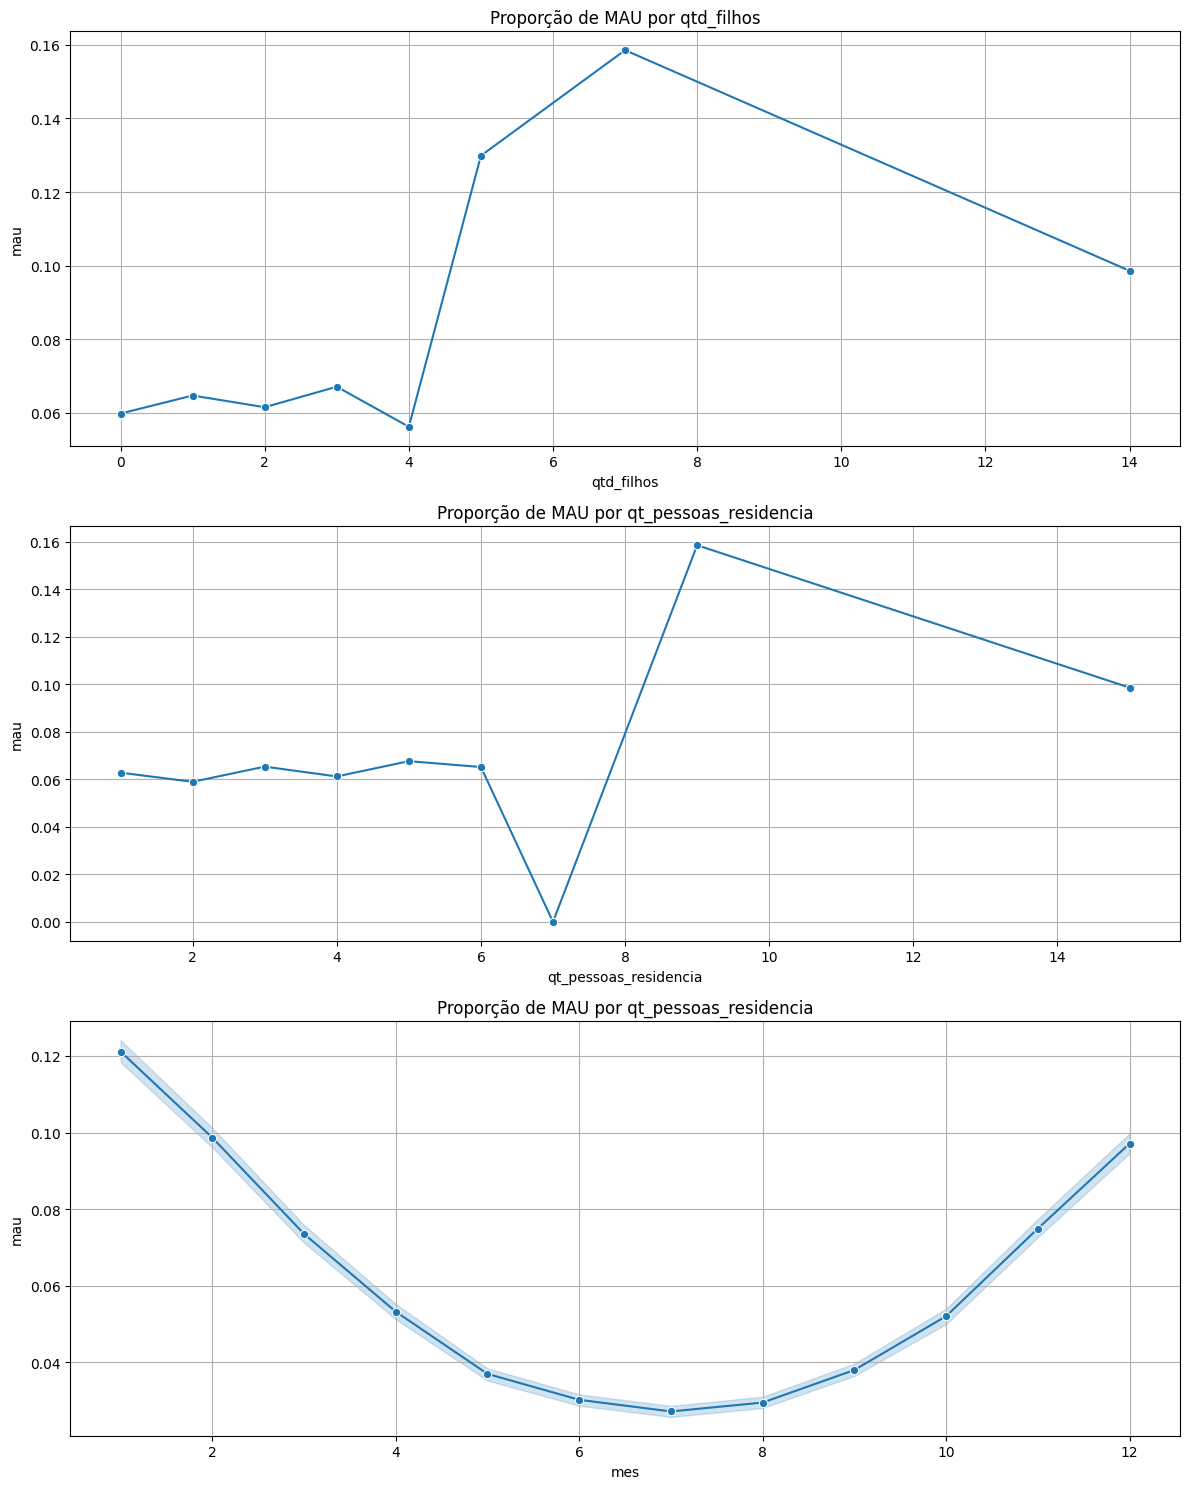

In [15]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize = (12, 15))

# Lineplot
# Calcular a média de qtd_filhos para cada categoria de MAU
media_filhos = df_train.groupby('qtd_filhos')['mau'].mean().reset_index()

# Plotar o gráfico de linha
sns.lineplot(data=media_filhos, x='qtd_filhos', y='mau', marker='o', ax=ax[0])
ax[0].set_title('Proporção de MAU por qtd_filhos')
ax[0].grid(True)

media_pessoas_residencia = df_train.groupby('qt_pessoas_residencia')['mau'].mean().reset_index()
sns.lineplot(data=media_pessoas_residencia, x='qt_pessoas_residencia', y='mau', marker='o', ax=ax[1])
ax[1].set_title('Proporção de MAU por qt_pessoas_residencia')
ax[1].grid(True)

sns.lineplot(data=df_train, x='mes', y='mau', marker='o', ax=ax[2])
ax[2].set_title('Proporção de MAU por qt_pessoas_residencia')
ax[2].grid(True)

plt.tight_layout()
plt.grid(True)
plt.show()

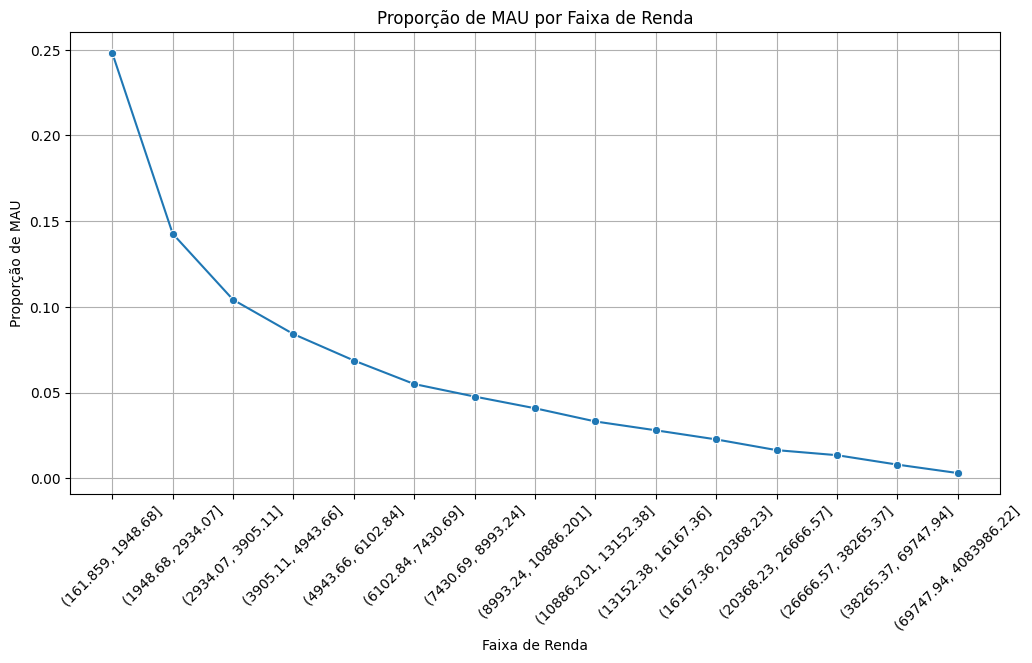

In [16]:
quebras = pd.qcut(df_train['renda'], 15, duplicates='drop').cat.categories

# Dividir a variável 'renda' em 15 intervalos
df_train['renda_bin'] = pd.cut(df_train['renda'],
                               bins=quebras,
                               labels=quebras,
                               include_lowest=True
                               )

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

# Lineplot
# Calcular a média de renda_bin para cada categoria de MAU
media_renda = df_train.groupby('renda_bin')['mau'].mean().reset_index()

# Convert the 'renda_bin' categories to strings for plotting
media_renda['renda_bin'] = media_renda['renda_bin'].astype(str)

sns.lineplot(data=media_renda, x='renda_bin', y='mau', marker='o', ax=ax)
plt.xticks(rotation=45)
plt.xlabel('Faixa de Renda')
plt.ylabel('Proporção de MAU')
plt.title('Proporção de MAU por Faixa de Renda')
plt.grid(True)
plt.show()

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [17]:
# df_train2 tem tempo_emprego tratado dos missing.
df_train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               600000 non-null  datetime64[ns]
 1   index                  600000 non-null  int64         
 2   sexo                   600000 non-null  object        
 3   posse_de_veiculo       600000 non-null  object        
 4   posse_de_imovel        600000 non-null  object        
 5   qtd_filhos             600000 non-null  int64         
 6   tipo_renda             600000 non-null  object        
 7   educacao               600000 non-null  object        
 8   estado_civil           600000 non-null  object        
 9   tipo_residencia        600000 non-null  object        
 10  idade                  600000 non-null  int64         
 11  tempo_emprego          600000 non-null  float64       
 12  qt_pessoas_residencia  600000 non-null  floa

In [18]:
df_train2['mau'] = df_train2['mau'].astype(int)
df_train2.drop(columns=['data_ref', 'index', 'mes', 'tempo_emprego_bin'], inplace=True)
df_train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   sexo                   600000 non-null  object 
 1   posse_de_veiculo       600000 non-null  object 
 2   posse_de_imovel        600000 non-null  object 
 3   qtd_filhos             600000 non-null  int64  
 4   tipo_renda             600000 non-null  object 
 5   educacao               600000 non-null  object 
 6   estado_civil           600000 non-null  object 
 7   tipo_residencia        600000 non-null  object 
 8   idade                  600000 non-null  int64  
 9   tempo_emprego          600000 non-null  float64
 10  qt_pessoas_residencia  600000 non-null  float64
 11  renda                  600000 non-null  float64
 12  mau                    600000 non-null  int64  
dtypes: float64(3), int64(3), object(7)
memory usage: 59.5+ MB


In [19]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]

    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [20]:
metadados = pd.DataFrame(df_train2.dtypes, columns=['dtype'])
metadados['nmissing'] = df_train2.isna().sum()
metadados['valores_unicos'] = df_train2.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'
metadados

,dtype,nmissing,valores_unicos,papel
sexo,object,0,2,covariavel
posse_de_veiculo,object,0,2,covariavel
posse_de_imovel,object,0,2,covariavel
qtd_filhos,int64,0,8,covariavel
tipo_renda,object,0,5,covariavel
educacao,object,0,5,covariavel
estado_civil,object,0,5,covariavel
tipo_residencia,object,0,6,covariavel
idade,int64,0,47,covariavel
tempo_emprego,float64,0,3005,covariavel


In [21]:
for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'valores_unicos']>10):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df_train2[var],5,duplicates='drop'), df_train2.mau)
    else:
        metadados.loc[var, 'IV'] = IV(df_train2[var], df_train2.mau)


metadados

,dtype,nmissing,valores_unicos,papel,IV
sexo,object,0,2,covariavel,0.002665
posse_de_veiculo,object,0,2,covariavel,0.000075
posse_de_imovel,object,0,2,covariavel,0.009690
qtd_filhos,int64,0,8,covariavel,0.001689
tipo_renda,object,0,5,covariavel,0.009718
educacao,object,0,5,covariavel,0.003690
estado_civil,object,0,5,covariavel,0.001305
tipo_residencia,object,0,6,covariavel,0.003330
idade,int64,0,47,covariavel,0.018434
tempo_emprego,float64,0,3005,covariavel,0.283956


# Análise variáveis discretas

In [22]:
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(),
                        var: g['mau'].mean().index,
                        'cont':g[var].count()})

    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep

    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')

    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)

    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=6)

    ax[1] = biv.cont.plot.bar()
    ax[1].set_xticklabels(rotation = 8,
                          labels=biv[var],
                          )

    return biv

In [23]:
df_train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   sexo                   600000 non-null  object 
 1   posse_de_veiculo       600000 non-null  object 
 2   posse_de_imovel        600000 non-null  object 
 3   qtd_filhos             600000 non-null  int64  
 4   tipo_renda             600000 non-null  object 
 5   educacao               600000 non-null  object 
 6   estado_civil           600000 non-null  object 
 7   tipo_residencia        600000 non-null  object 
 8   idade                  600000 non-null  int64  
 9   tempo_emprego          600000 non-null  float64
 10  qt_pessoas_residencia  600000 non-null  float64
 11  renda                  600000 non-null  float64
 12  mau                    600000 non-null  int64  
dtypes: float64(3), int64(3), object(7)
memory usage: 59.5+ MB


## Sexo

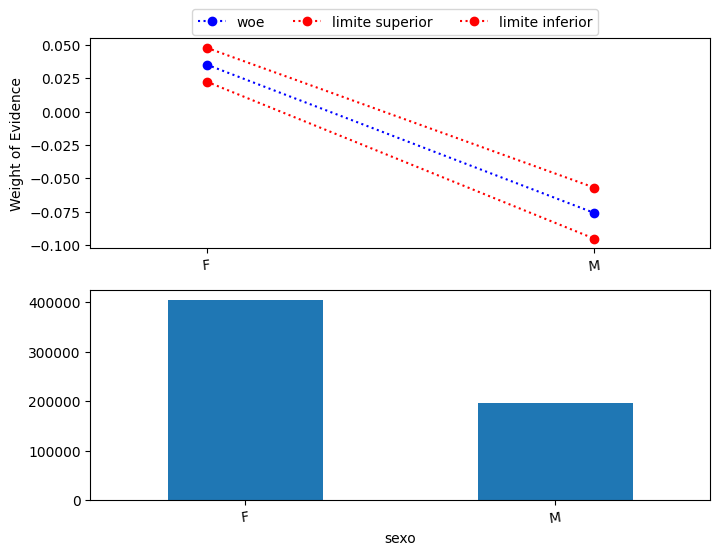

In [24]:
biv_discreta('sexo', df_train2);

## Posse de Veículo

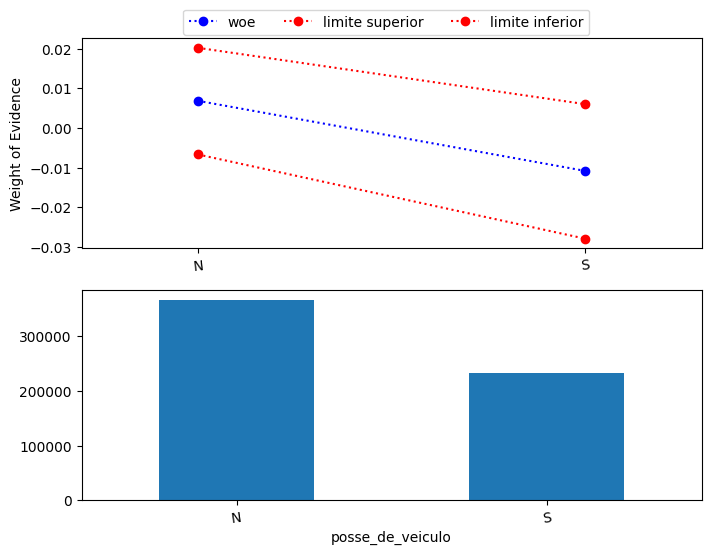

In [25]:
biv_discreta('posse_de_veiculo', df_train2);

## Posse de Imóvel

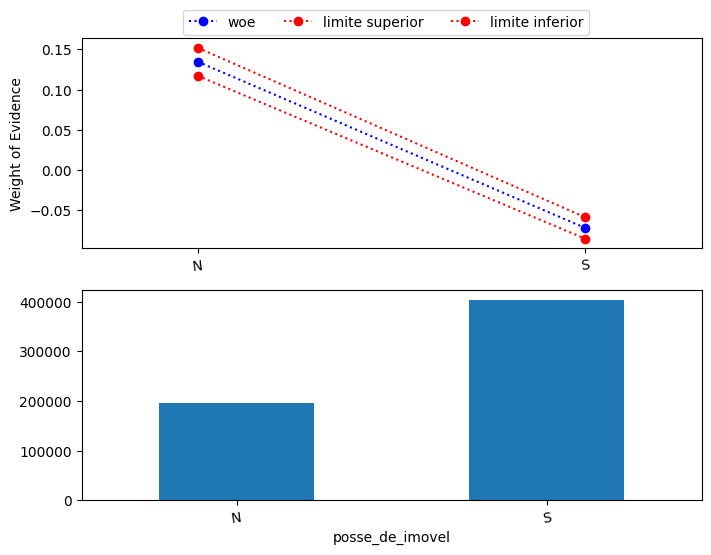

In [26]:
biv_discreta('posse_de_imovel', df_train2);

## Quantidade de Filhos

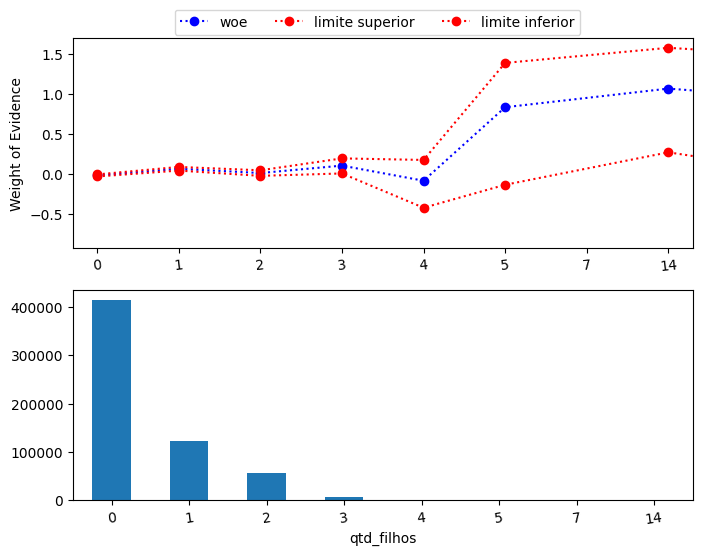

In [27]:
biv_discreta('qtd_filhos', df_train2);

0.001323320930508114

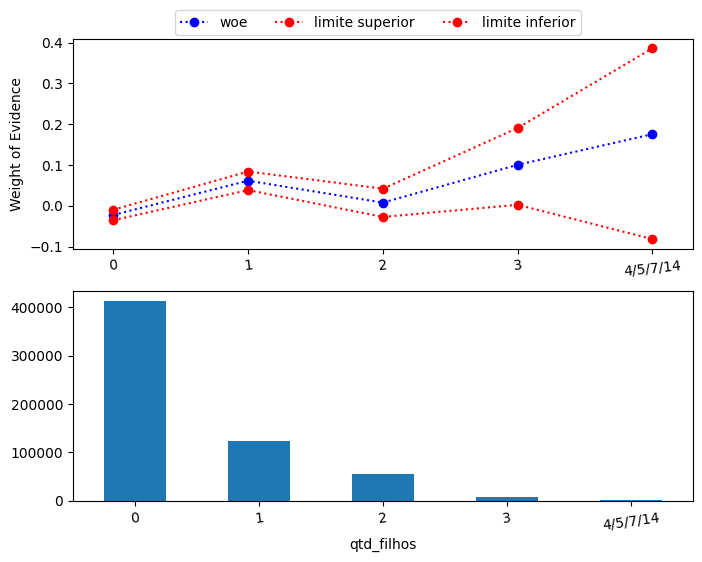

In [28]:
# Agrupando as classes da variável qtd_filhos
df_train2['qtd_filhos'] = df_train2['qtd_filhos'].astype(str)

df_train2.qtd_filhos.replace(
    {'4': '4/5/7/14',
     '5': '4/5/7/14',
     '7': '4/5/7/14',
     '14': '4/5/7/14'}, inplace=True)

biv_discreta('qtd_filhos', df_train2)
IV(df_train2.qtd_filhos, df_train2.mau)

## Tipo de Renda

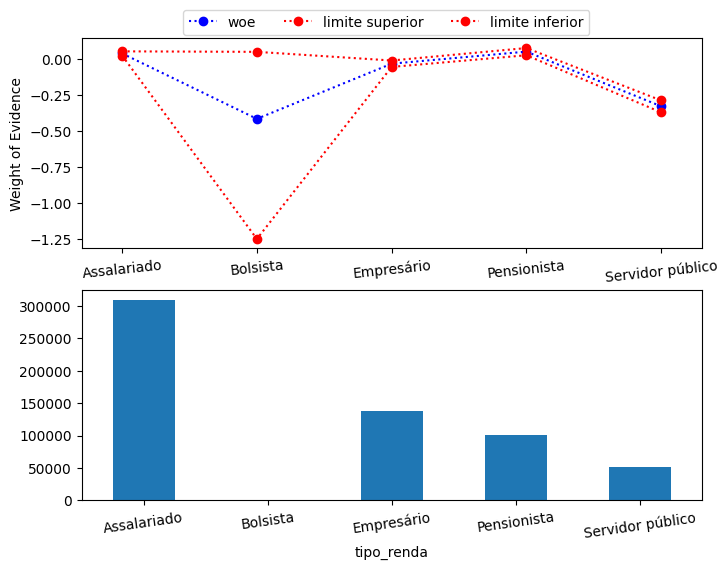

In [29]:
biv_discreta('tipo_renda', df_train2);

0.009634301334170859

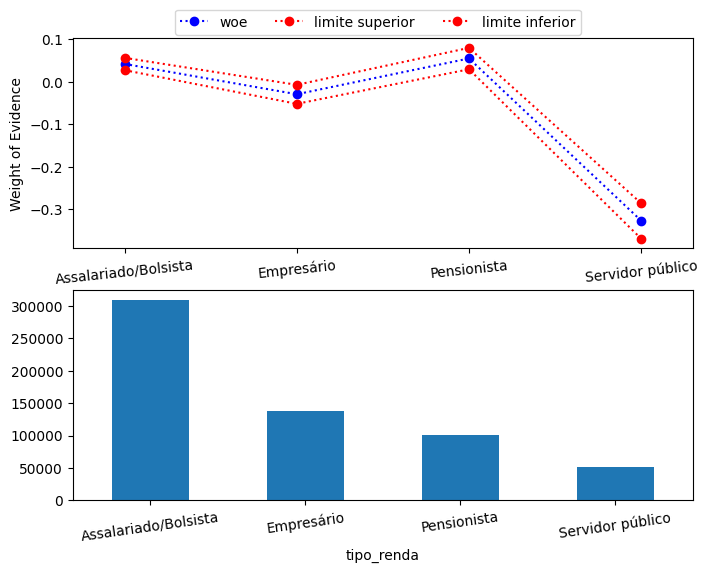

In [30]:
# Agrupando as classes da variável educacao
df_train2.tipo_renda.replace(
    {'Assalariado': 'Assalariado/Bolsista',
     'Bolsista': 'Assalariado/Bolsista'}, inplace=True)

biv_discreta('tipo_renda', df_train2)
IV(df_train2.tipo_renda, df_train2.mau)

## Educação

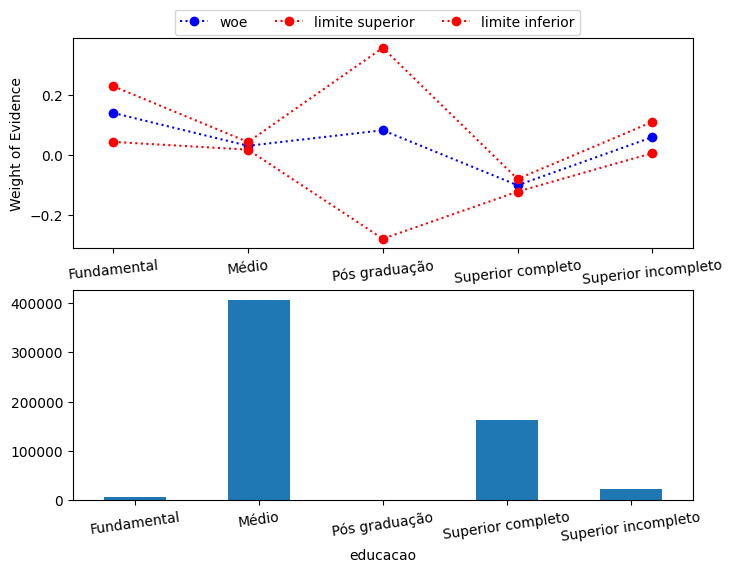

In [31]:
biv_discreta('educacao', df_train2);

0.0034801108923340892

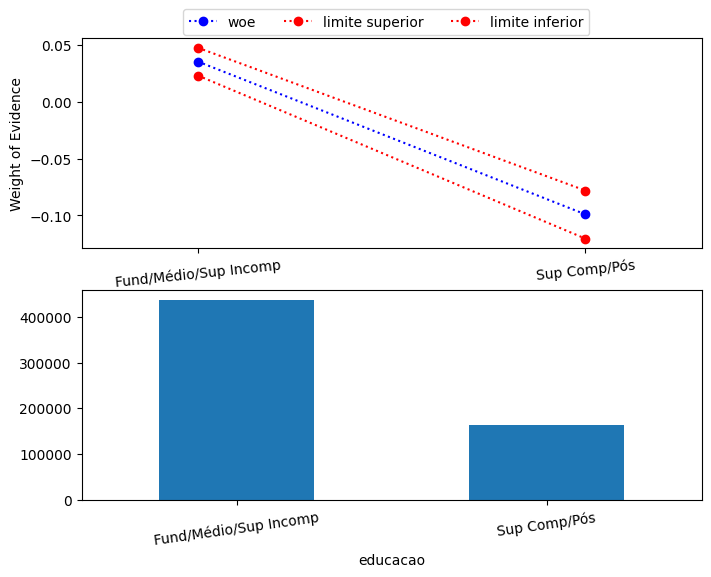

In [32]:
# Agrupando as classes da variável educacao

df_train2.educacao.replace(
    {'Fundamental': 'Fund/Médio/Sup Incomp',
     'Médio': 'Fund/Médio/Sup Incomp',
     'Superior incompleto': 'Fund/Médio/Sup Incomp',
     'Superior completo': 'Sup Comp/Pós',
     'Pós graduação': 'Sup Comp/Pós'}, inplace=True)

biv_discreta('educacao', df_train2)
IV(df_train2.educacao, df_train2.mau)

## Estado Civil

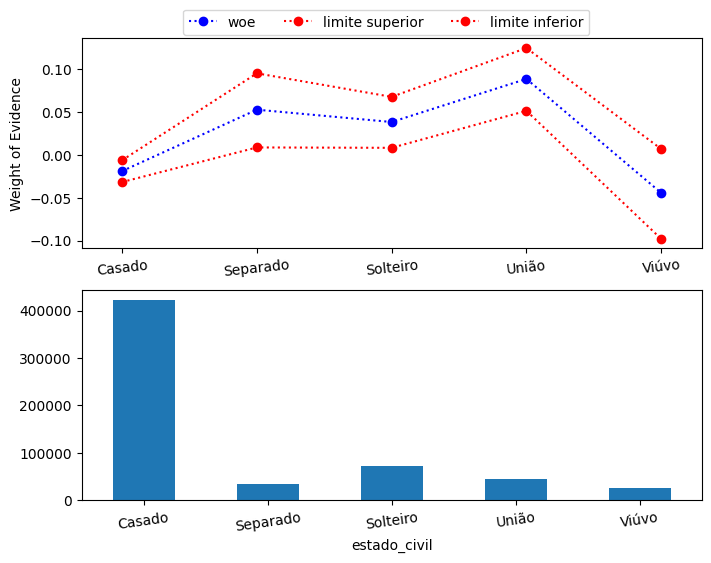

In [33]:
biv_discreta('estado_civil', df_train2);

## Tipo de Residencia

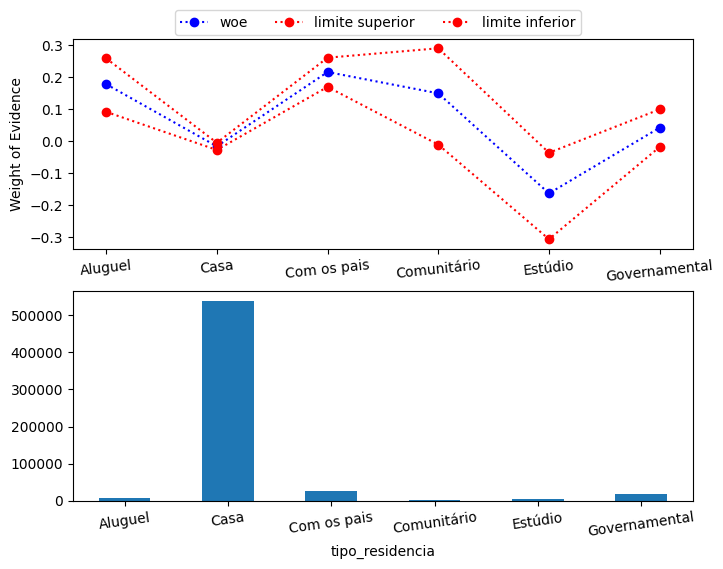

In [34]:
biv_discreta('tipo_residencia', df_train2);

0.0027708278973644224

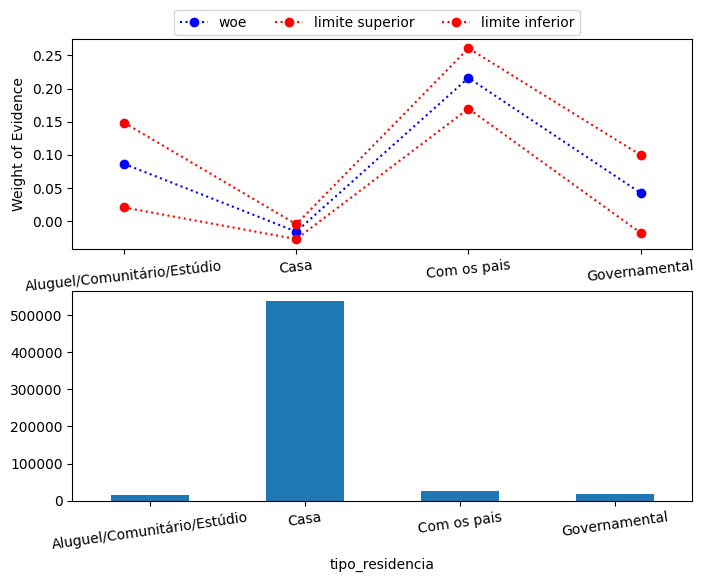

In [35]:
# Agrupando as classes da variável tipo_residencia.

df_train2.tipo_residencia.replace(
    {'Aluguel': 'Aluguel/Comunitário/Estúdio',
     'Comunitário': 'Aluguel/Comunitário/Estúdio',
     'Estúdio': 'Aluguel/Comunitário/Estúdio'}
     ,inplace=True)

biv_discreta('tipo_residencia', df_train2)
IV(df_train2.tipo_residencia, df_train2.mau)

## Quantidade de Pessoas por Residência

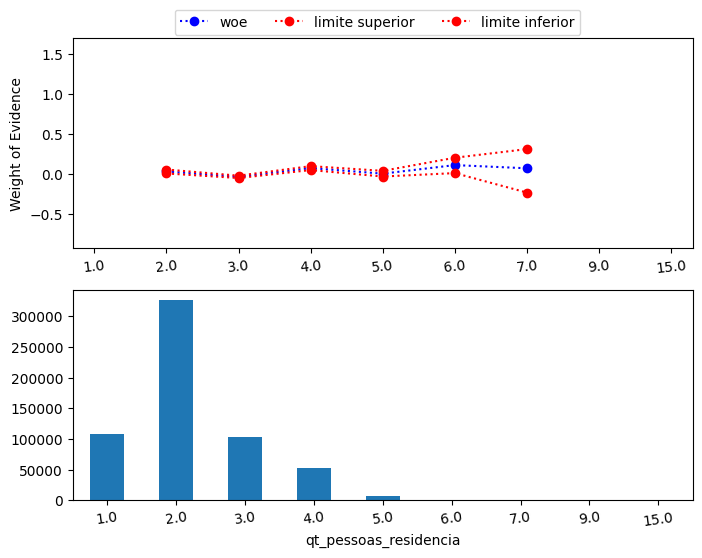

In [36]:
biv_discreta('qt_pessoas_residencia', df_train2);

0.0020417011346501365

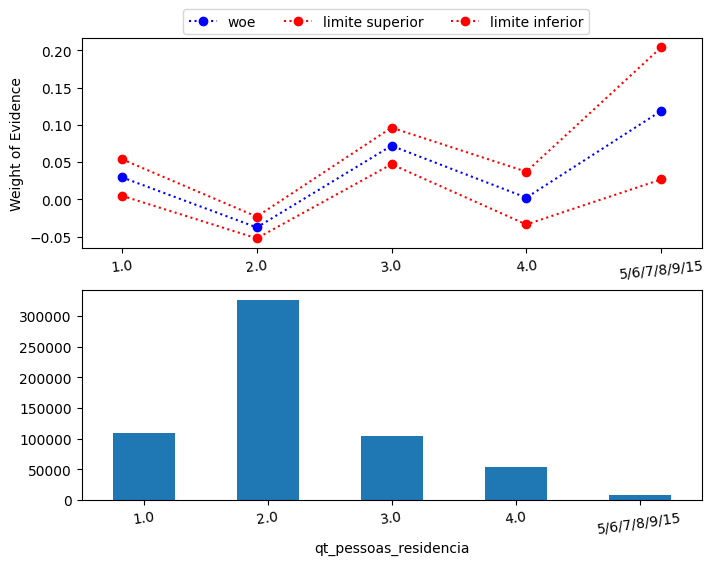

In [37]:
df_train2.qt_pessoas_residencia = df_train2.qt_pessoas_residencia.astype(str)

df_train2.qt_pessoas_residencia.replace(
    {'5.0': '5/6/7/8/9/15',
     '6.0': '5/6/7/8/9/15',
     '7.0': '5/6/7/8/9/15',
     '8.0': '5/6/7/8/9/15',
     '9.0': '5/6/7/8/9/15',
     '15.0': '5/6/7/8/9/15'}, inplace=True)

biv_discreta('qt_pessoas_residencia', df_train2)
IV(df_train2.qt_pessoas_residencia, df_train2.mau)

# Análise variáveis continuas

In [38]:
def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(),
                        var: g[var].mean(),
                        'cont':g[var].count()})

    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep

    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')

    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)

    ax[1] = biv.cont.plot.bar()
    return None

## Idade

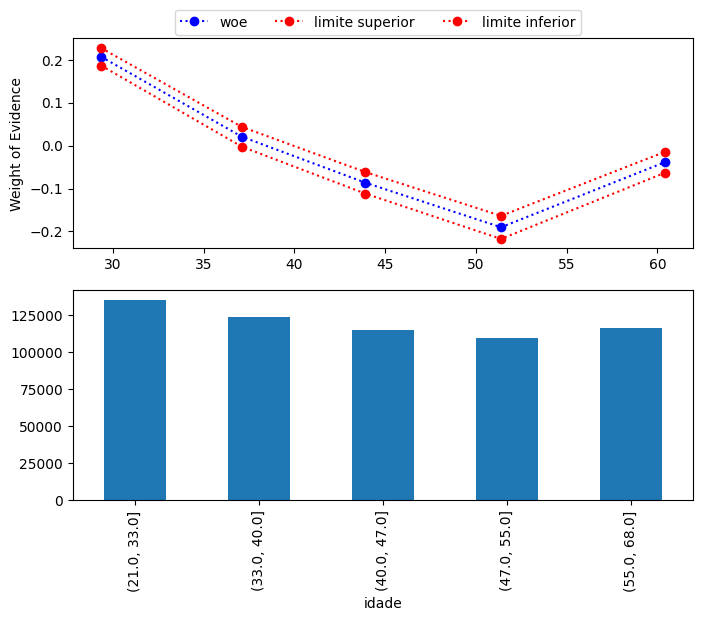

In [39]:
biv_continua('idade', 5, df_train2)

## Tempo de Emprego

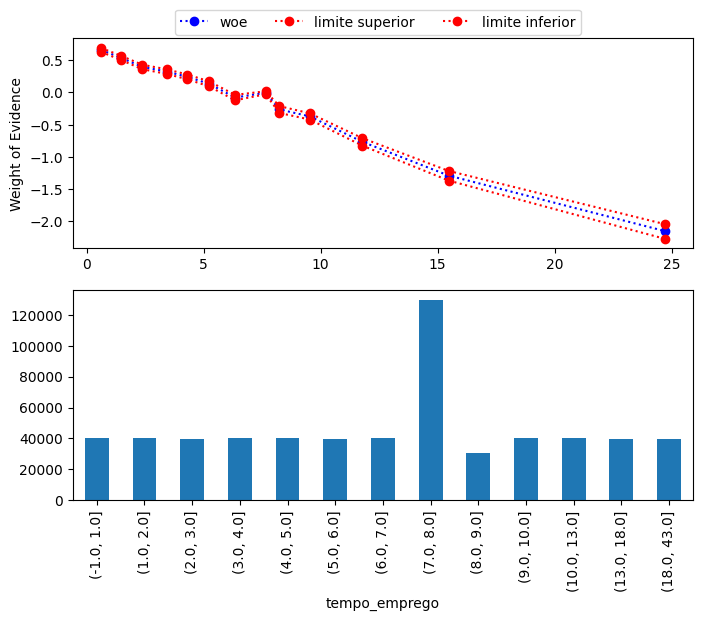

In [40]:
biv_continua('tempo_emprego', 15, df_train2)

## Renda

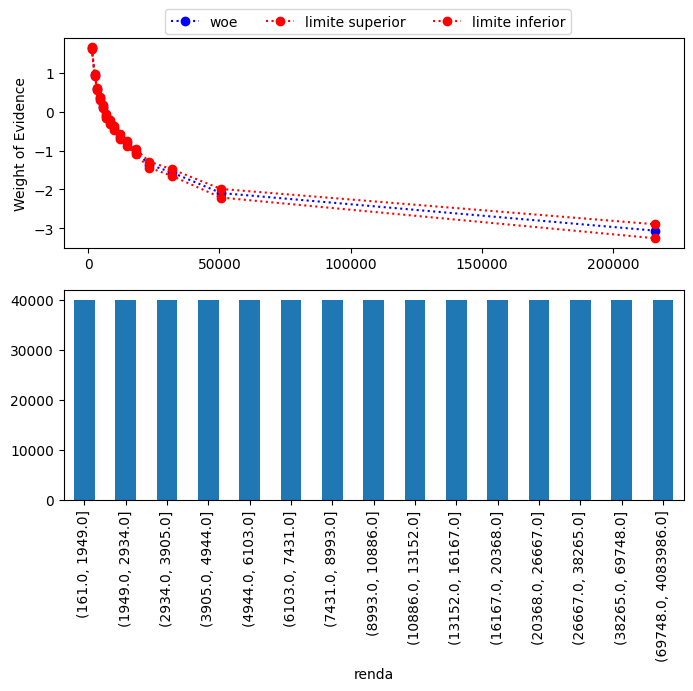

In [41]:
biv_continua('renda', 15, df_train2)

# Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [42]:
# ajuda para definir a equação da regressão
' + '.join(list(df_train2.columns))

'sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia + idade + tempo_emprego + qt_pessoas_residencia + renda + mau + bom'

In [43]:
metadados.sort_values(by='IV', ascending=False)

,dtype,nmissing,valores_unicos,papel,IV
qt_pessoas_residencia,float64,0,9,covariavel,inf
renda,float64,0,112472,covariavel,0.959826
tempo_emprego,float64,0,3005,covariavel,0.283956
idade,int64,0,47,covariavel,0.018434
tipo_renda,object,0,5,covariavel,0.009718
posse_de_imovel,object,0,2,covariavel,0.009690
educacao,object,0,5,covariavel,0.003690
tipo_residencia,object,0,6,covariavel,0.003330
sexo,object,0,2,covariavel,0.002665
qtd_filhos,int64,0,8,covariavel,0.001689


Pelos valores de IV do "tipo_renda" e "posse_de_imovel" serem 0.009 (quase 0.01), irei utilizar inicialmente

In [44]:
formula = '''
          mau ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos +
          tipo_renda + educacao + estado_civil + tipo_residencia +
          qt_pessoas_residencia + idade + tempo_emprego + renda
          '''

r1 = smf.glm(formula=formula, data=df_train2, family=sm.families.Binomial()).fit()
r1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599974
Model Family:                Binomial   Df Model:                           25
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2488e+05
Date:                Tue, 30 Jul 2024   Deviance:                   2.4965e+05
Time:                        15:56:38   Pearson chi2:                 1.57e+16
No. Iterations:                    11   Pseudo R-squ. (CS):            0.04260
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                -1.3735      0.101    -13.557      0.000      -1.572      -1.175
sexo[T.M]                                -0.1250      0.013     -9.515      0.000      -0.151      -0.099
posse_de_veiculo[T.S]                     0.0308      0.012      2.489      0.013       0.007       0.055
posse_de_imovel[T.S]                     -0.0844      0.012     -7.149      0.000      -0.108      -0.061
qtd_filhos[T.1]                           0.0913      0.092      0.990      0.322      -0.089       0.272
qtd_filhos[T.2]                           0.1564      0.188      0.830      0.407      -0.213       0.526
qtd_filhos[T.3]                           0.3916      0.370      1.059      0.289      -0.333       1.116
qtd_filhos[T.4/5/7/14]                    0.3514      0.400      0.878      0.380      -0.433       1.136
tipo_renda[T.Empresário]                 -0.0547      0.014     -3.909      0.000      -0.082      -0.027
tipo_renda[T.Pensionista]                -0.0397      0.020     -1.965      0.049      -0.079      -0.000
tipo_renda[T.Servidor público]           -0.0328      0.023     -1.412      0.158      -0.078       0.013
educacao[T.Sup Comp/Pós]                 -0.0568      0.013     -4.339      0.000      -0.082      -0.031
estado_civil[T.Separado]                 -0.0391      0.092     -0.425      0.671      -0.219       0.141
estado_civil[T.Solteiro]                 -0.0691      0.091     -0.762      0.446      -0.247       0.109
estado_civil[T.União]                     0.0477      0.020      2.343      0.019       0.008       0.088
estado_civil[T.Viúvo]                    -0.1094      0.095     -1.157      0.247      -0.295       0.076
tipo_residencia[T.Casa]                  -0.0543      0.034     -1.596      0.111      -0.121       0.012
tipo_residencia[T.Com os pais]           -0.0389      0.041     -0.946      0.344      -0.119       0.042
tipo_residencia[T.Governamental]         -0.0505      0.045     -1.111      0.266      -0.139       0.039
qt_pessoas_residencia[T.2.0]             -0.0703      0.090     -0.777      0.437      -0.248       0.107
qt_pessoas_residencia[T.3.0]             -0.1669      0.180     -0.930      0.352      -0.519       0.185
qt_pessoas_residencia[T.4.0]             -0.2391      0.272     -0.880      0.379      -0.772       0.294
qt_pessoas_residencia[T.5/6/7/8/9/15]    -0.3869      0.440     -0.880      0.379      -1.249       0.475
idade                                     0.0001      0.001      0.179      0.858      -0.001       0.002
tempo_emprego                            -0.0235      0.002    -13.074      0.000      -0.027      -0.020
renda                                    -0.0001   1.09e-06    -93.683      0.000      -0.000   -9.96e-05
=========

In [45]:
formula = '''
          mau ~ sexo + renda + tempo_emprego + idade +
          educacao + posse_de_imovel + posse_de_veiculo + tipo_renda
          '''

r2 = smf.glm(formula=formula, data=df_train2, family=sm.families.Binomial()).fit()
r2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599989
Model Family:                Binomial   Df Model:                           10
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2489e+05
Date:                Tue, 30 Jul 2024   Deviance:                   2.4967e+05
Time:                        15:56:58   Pearson chi2:                 1.57e+16
No. Iterations:                    11   Pseudo R-squ. (CS):            0.04257
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -1.4816      0.029    -51.092      0.000      -1.538      -1.425
sexo[T.M]                         -0.1244      0.013     -9.528      0.000      -0.150      -0.099
educacao[T.Sup Comp/Pós]          -0.0574      0.013     -4.403      0.000      -0.083      -0.032
posse_de_imovel[T.S]              -0.0874      0.012     -7.567      0.000      -0.110      -0.065
posse_de_veiculo[T.S]              0.0289      0.012      2.362      0.018       0.005       0.053
tipo_renda[T.Empresário]          -0.0535      0.014     -3.843      0.000      -0.081      -0.026
tipo_renda[T.Pensionista]         -0.0439      0.020     -2.189      0.029      -0.083      -0.005
tipo_renda[T.Servidor público]    -0.0343      0.023     -1.477      0.140      -0.080       0.011
renda                             -0.0001   1.09e-06    -93.706      0.000      -0.000   -9.96e-05
tempo_emprego                     -0.0237      0.002    -13.187      0.000      -0.027      -0.020
idade                          -2.412e-05      0.001     -0.037      0.970      -0.001       0.001
==================================================================================================
"""

In [46]:
formula = '''
          mau ~ sexo + renda + tempo_emprego + educacao +
          posse_de_imovel + posse_de_veiculo + tipo_renda
          '''

r3 = smf.glm(formula=formula, data=df_train2, family=sm.families.Binomial()).fit()
r3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599990
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2489e+05
Date:                Tue, 30 Jul 2024   Deviance:                   2.4967e+05
Time:                        15:57:13   Pearson chi2:                 1.57e+16
No. Iterations:                    11   Pseudo R-squ. (CS):            0.04257
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -1.4825      0.015   -100.065      0.000      -1.512      -1.453
sexo[T.M]                         -0.1243      0.013     -9.569      0.000      -0.150      -0.099
educacao[T.Sup Comp/Pós]          -0.0573      0.013     -4.426      0.000      -0.083      -0.032
posse_de_imovel[T.S]              -0.0874      0.011     -7.608      0.000      -0.110      -0.065
posse_de_veiculo[T.S]              0.0289      0.012      2.366      0.018       0.005       0.053
tipo_renda[T.Empresário]          -0.0535      0.014     -3.843      0.000      -0.081      -0.026
tipo_renda[T.Pensionista]         -0.0443      0.016     -2.716      0.007      -0.076      -0.012
tipo_renda[T.Servidor público]    -0.0343      0.023     -1.476      0.140      -0.080       0.011
renda                             -0.0001   1.08e-06    -93.776      0.000      -0.000   -9.96e-05
tempo_emprego                     -0.0237      0.002    -13.250      0.000      -0.027      -0.020
==================================================================================================
"""

In [47]:
formula = '''
          mau ~ sexo + np.log(renda) + tempo_emprego + educacao +
          posse_de_imovel + posse_de_veiculo + tipo_renda
          '''

r4 = smf.glm(formula=formula, data=df_train2, family=sm.families.Binomial()).fit()
r4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599990
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2027e+05
Date:                Tue, 30 Jul 2024   Deviance:                   2.4054e+05
Time:                        15:57:26   Pearson chi2:                 5.98e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.05721
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          5.9072      0.051    114.716      0.000       5.806       6.008
sexo[T.M]                         -0.0101      0.013     -0.764      0.445      -0.036       0.016
educacao[T.Sup Comp/Pós]          -0.0074      0.013     -0.564      0.573      -0.033       0.018
posse_de_imovel[T.S]              -0.0190      0.012     -1.611      0.107      -0.042       0.004
posse_de_veiculo[T.S]              0.0276      0.012      2.215      0.027       0.003       0.052
tipo_renda[T.Empresário]          -0.0033      0.014     -0.233      0.816      -0.031       0.025
tipo_renda[T.Pensionista]          0.0175      0.016      1.064      0.287      -0.015       0.050
tipo_renda[T.Servidor público]     0.0046      0.024      0.194      0.846      -0.042       0.051
np.log(renda)                     -0.9873      0.007   -148.909      0.000      -1.000      -0.974
tempo_emprego                     -0.0016      0.002     -0.913      0.361      -0.005       0.002
==================================================================================================
"""

In [48]:
formula = 'mau ~ np.log(renda) + posse_de_veiculo'

r5 = smf.glm(formula=formula, data=df_train2, family=sm.families.Binomial()).fit()
r5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599997
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2027e+05
Date:                Tue, 30 Jul 2024   Deviance:                   2.4055e+05
Time:                        15:57:29   Pearson chi2:                 5.97e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.05720
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 5.9185      0.049    121.064      0.000       5.823       6.014
posse_de_veiculo[T.S]     0.0222      0.012      1.929      0.054      -0.000       0.045
np.log(renda)            -0.9912      0.006   -169.804      0.000      -1.003      -0.980
=========================================================================================
"""

In [49]:
df_train2['score'] = r5.predict(df_train2)

# Acurácia
acc = metrics.accuracy_score(df_train2.mau, df_train2.score>.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df_train2.mau, df_train2.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df_train2.loc[df_train2.mau == 1, 'score'], df_train2.loc[df_train2.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))


Acurácia: 71.9% 
AUC: 77.0% 
GINI: 54.0%
KS: 39.8%


## Aplicação na base de teste


In [50]:
df_test2 = df_test.copy()
df_test2['tempo_emprego'] = df_test2['tempo_emprego'].fillna(df_test2['tempo_emprego'].mean())

# Refazendo o que foi feito na base de treino
df_test2['qtd_filhos'] = df_test2['qtd_filhos'].astype(str)

df_test2.qtd_filhos.replace({'4': '4/5/7/14',
                             '5': '4/5/7/14',
                             '7': '4/5/7/14',
                             '14': '4/5/7/14'}, inplace=True)

df_test2.tipo_renda.replace({'Assalariado': 'Assalariado/Bolsista',
                             'Bolsista': 'Assalariado/Bolsista'}, inplace=True)

df_test2.educacao.replace({'Fundamental': 'Fund/Médio/Sup Incomp',
                           'Médio': 'Fund/Médio/Sup Incomp',
                           'Superior incompleto': 'Fund/Médio/Sup Incomp',
                           'Superior completo': 'Sup Comp/Pós',
                           'Pós graduação': 'Sup Comp/Pós'}, inplace=True)

df_test2.tipo_residencia.replace({'Aluguel': 'Aluguel/Comunitário/Estúdio',
                                  'Comunitário': 'Aluguel/Comunitário/Estúdio',
                                  'Estúdio': 'Aluguel/Comunitário/Estúdio'}
                                 ,inplace=True)

df_test2.qt_pessoas_residencia = df_train2.qt_pessoas_residencia.astype(str)

df_test2.qt_pessoas_residencia.replace({'5.0': '5/6/7/8/9/15',
                                        '6.0': '5/6/7/8/9/15',
                                        '7.0': '5/6/7/8/9/15',
                                        '8.0': '5/6/7/8/9/15',
                                        '9.0': '5/6/7/8/9/15',
                                        '15.0': '5/6/7/8/9/15'}, inplace=True)

In [51]:
df_test2['score'] = r5.predict(df_test2)

# Acurácia
acc = metrics.accuracy_score(df_test2.mau, df_test2.score>.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df_test2.mau, df_test2.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df_test2.loc[df_test2.mau == 1, 'score'], df_test2.loc[df_test2.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Acurácia: 39.2% 
AUC: 73.9% 
GINI: 47.8%
KS: 34.6%
